In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import pygad

import HydroErr

c:\Users\User\Anaconda3\envs\pytorch1.13\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 559

# training hyperparameters
EPOCHS = 500
TRAIN_YEAR = 19
PATIENCE = 20

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [3]:
embedding = torch.load("data/model/lstm_embedding.pt", map_location=torch.device('cpu')).to(computing_device)
decoder = torch.load("data/model/lstm_decoder.pt", map_location=torch.device('cpu')).to(computing_device)

embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]
LATENT_dim = catchment_embeddings.shape[1]

In [4]:
decoder

LSTM_decoder(
  (lstm): LSTM(7, 220, batch_first=True)
  (fc_layers): TimeDistributed(
    (module): Sequential(
      (0): Linear(in_features=220, out_features=13, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=13, out_features=6, bias=True)
      (4): ReLU()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=6, out_features=1, bias=True)
    )
  )
)

In [5]:
dtrain_val = dataloader.Forcing_Data(
    "./data/camels_train_val.csv",
    record_length=3652,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtrain = dataloader.Forcing_Data(
    "./data/camels_train.csv",
    record_length=2922,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dval = dataloader.Forcing_Data(
    "./data/camels_val.csv",
    record_length=1095,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtest = dataloader.Forcing_Data(
    "./data/camels_test.csv",
    record_length=4383,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [6]:
def pred_hydrograph(code, x):

    record_length = x.shape[1]

    # iterate over each year for the selected catchments
    n_years = math.floor((record_length - BASE_LENGTH) / TARGET_SEQ_LENGTH)

    preds = torch.ones(record_length).to(computing_device)*torch.nan

    for k in range(n_years):
        start_record_ind = BASE_LENGTH + k * TARGET_SEQ_LENGTH
        end_record_ind = start_record_ind + TARGET_SEQ_LENGTH

        # dealing with the unique length of the last year record
        if k == (n_years - 1):
            end_record_ind = record_length

        # subsetting, base length is included
        x_sub = x[:, (start_record_ind - BASE_LENGTH) : end_record_ind, :]

        # pass through decoder, and store the result into `preds`
        with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=use_amp
            ):
            with torch.no_grad():
                preds[start_record_ind:end_record_ind] = decoder.decode(code, x_sub)
        
    return(preds[BASE_LENGTH:])

In [7]:
class Objective_builder:
    def __init__(self, x, y, eval_fun):
        self.eval_fun = eval_fun
        self.x = x
        self.y = y
    
    def eval(self, code, return_summary = True):
        
        # numpy to torch tensor
        code = torch.from_numpy(code).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
        
        # BASE_LENGTH is from global
        pred = pred_hydrograph(code,self.x).cpu().detach().numpy()
        ob = self.y[:,BASE_LENGTH:].squeeze().cpu().detach().numpy()
        
        if return_summary:
             return self.eval_fun(simulated_array=pred, observed_array=ob)
        else:
            return pred, ob

In [8]:
num_generations = 50
num_parents_mating = 4

sol_per_pop = 50
num_genes = LATENT_dim

init_range_low = -5
init_range_high = 5

parent_selection_type = "sss"

crossover_type = "single_point"

mutation_type = "random"
mutation_probability = 0.25

def evaluate_calibration(selected_catchment=[0]):
    
    x = dtrain.x[selected_catchment]
    y = dtrain.y[selected_catchment]

    x, y = x.to(computing_device), y.to(computing_device)

    fn = Objective_builder(x,y,HydroErr.kge_2009)

    def fitness_func(solution, solution_idx):
        return fn.eval(solution)

    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_func,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        init_range_low=init_range_low,
                        init_range_high=init_range_high,
                        parent_selection_type=parent_selection_type,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_probability = mutation_probability)

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    # evaluate on test dataset
    x = dtest.x[selected_catchment]
    y = dtest.y[selected_catchment]

    x, y = x.to(computing_device), y.to(computing_device)

    fn = Objective_builder(x,y,HydroErr.kge_2009)

    return fn.eval(solution)


In [9]:
N_CATCHMENTS = 20
calibrated_KGES = np.ones(N_CATCHMENTS)

for i in range(N_CATCHMENTS):
    print(f'i={i} starts')
    calibrated_KGES[i] = evaluate_calibration([i])
    print("\n")

i=0 starts


i=1 starts


i=2 starts


i=3 starts


i=4 starts


i=5 starts


i=6 starts


i=7 starts


i=8 starts


i=9 starts


i=10 starts


i=11 starts


i=12 starts


i=13 starts


i=14 starts


i=15 starts


i=16 starts


i=17 starts


i=18 starts


i=19 starts




In [10]:
calibrated_KGES

array([0.64035545, 0.83774665, 0.68741829, 0.74604861, 0.73888305,
       0.76106733, 0.52094301, 0.63204021, 0.64197981, 0.47789245,
       0.44529291, 0.56352009, 0.74570998, 0.69454347, 0.50037421,
       0.50568988, 0.53431284, 0.59366638, 0.61392164, 0.64343483])

In [15]:
calibrated_KGES

array([ 3.68465379e-01,  4.30813003e-01,  3.84544370e-01,  3.92909455e-01,
        4.03020138e-01,  2.52027951e-01,  2.32128449e-01,  2.66625153e-01,
        4.39365295e-01,  4.90271430e-01,  3.72791553e-01,  3.71478866e-01,
        3.99828770e-01,  4.45838943e-01,  3.97063941e-01,  3.79567516e-01,
        3.39348909e-01,  4.58646336e-01,  4.74134986e-01,  5.06719075e-01,
        4.11992438e-01,  4.96153703e-01,  3.36959656e-01,  3.44994127e-01,
        5.54788634e-01,  3.94507039e-01,  4.41753713e-01, -2.90710820e-01,
        4.35333716e-01,  5.30392328e-01,  4.05321112e-01,  3.94015251e-01,
        4.61384573e-01,  4.59759621e-01,  3.30386720e-01,  3.17419376e-01,
        3.19606444e-01,  2.29067859e-01,  1.82640739e-01,  1.12859334e-01,
        3.67037467e-01, -5.02547369e-02,  1.35684418e-01,  2.66136003e-01,
        2.93613560e-01,  2.45347126e-01,  2.71608156e-01,  2.42388020e-01,
        2.05825991e-01,  1.26837906e-01,  8.71323680e-02,  1.85366497e-01,
        2.07907745e-01,  

In [40]:
calibrated_KGES.max()

0.9194417028829057

In [22]:
calibrated_KGES.size

546

In [51]:
evaluate_calibration([2])

0.7892894999233896

In [17]:
np.savetxt("data/ga_KGEs.csv", calibrated_KGES, delimiter=",")

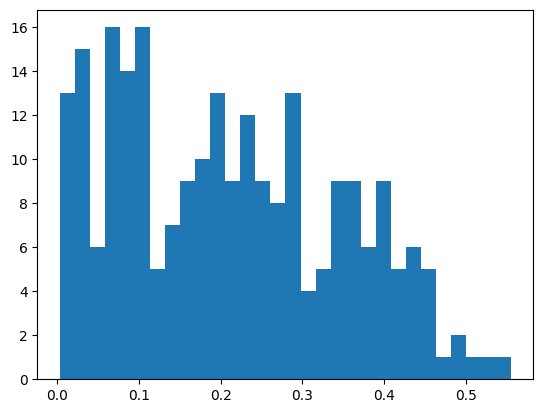

In [16]:
plt.hist(calibrated_KGES[calibrated_KGES>0], bins = 30)
plt.show()

In [20]:
calibrated_KGES.mean()

0.5206200703670887

In [24]:
N_CATCHMENT = train_val_batch_gen.dataset.x.shape[0]
calibrated_KGES = np.ones(N_CATCHMENT)
i = 0
calibrated_KGES[i] = evaluate_calibration([i])

In [47]:

selected_catchment = [110]

batch_gen = train_val_batch_gen

x = batch_gen.dataset.x[selected_catchment]
y = batch_gen.dataset.y[selected_catchment]

x, y = x.to(DEVICE), y.to(DEVICE)

In [50]:
fn = FN(x,y,HydroErr.kge_2009)

def fitness_func(solution, solution_idx):
    return fn.eval(solution)

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_probability = mutation_probability)

In [52]:
ga_instance.run()

In [53]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [ 2.39297483 -3.06968491 -2.88818786 -2.89980175]
Fitness value of the best solution = 0.5666582062553918


In [54]:
batch_gen = test_batch_gen

x = batch_gen.dataset.x[selected_catchment]
y = batch_gen.dataset.y[selected_catchment]

x, y = x.to(DEVICE), y.to(DEVICE)

fn = FN(x,y,HydroErr.kge_2009)

fn.eval(solution)

0.6630948503353136

In [126]:
scaler = 1.25

UB, _ = torch.max(
    embedding.weight,
    0,
)

LB, _ = torch.min(
    embedding.weight,
    0,
)

UB = UB + torch.abs(UB)*(scaler - 1)
LB = LB - torch.abs(LB)*(scaler - 1)

UB = UB.cpu().detach().numpy()
LB = LB.cpu().detach().numpy()